## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [10]:
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torchsummary import summary
from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print("Directory", path, "is created!")
    else:
        print("Directory", path, "already exists!")


root_path = "fmnist"
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path,
    train=True,
    transform=train_transform,
    target_transform=None,
    download=download,
)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path,
    train=False,
    transform=test_transform,
    target_transform=None,
    download=download,
)

In [5]:
validation_ratio = 0.2
generator = torch.Generator().manual_seed(42)
fmnist_dataset_train, fmnist_dataset_validation = torch.utils.data.random_split(
    fmnist_dataset_train, [1 - validation_ratio, validation_ratio], generator
)

In [6]:
len(fmnist_dataset_train), len(fmnist_dataset_validation), len(fmnist_dataset_test)

(48000, 12000, 10000)

In [46]:
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)
validation_loader = torch.utils.data.DataLoader(
    fmnist_dataset_validation, batch_size=128, shuffle=False, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2
)

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

#### FC NN

In [42]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64, bias=False),
            nn.GELU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 16, bias=False),
            nn.GELU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.3),
            nn.Linear(16, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [43]:
summary(TinyNeuralNetwork(), (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,352
       BatchNorm1d-3                  [-1, 128]             256
              GELU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,192
              GELU-7                   [-1, 64]               0
       BatchNorm1d-8                   [-1, 64]             128
            Linear-9                   [-1, 16]           1,024
             GELU-10                   [-1, 16]               0
      BatchNorm1d-11                   [-1, 16]              32
          Dropout-12                   [-1, 16]               0
           Linear-13                   [-1, 10]             170
Total params: 110,154
Trainable params:

Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [44]:
training_params = {"n_epochs": 20}
loss_history = {"train": [], "validation": []}
accuracy_history = {"train": [], "validation": []}

In [54]:
def train(
    model,
    opt,
    loss_func,
    training_params,
    loss_history,
    accuracy_history,
    train_loader,
    validation_loader,
):
    for epoch in range(training_params["n_epochs"]):
        model.train()
        train_loss_batch = []
        correct_train_predictions = 0
        total_train_predictions = 0

        train_progress_bar = tqdm(
            train_loader,
            desc=f"Epoch {epoch + 1}/{training_params['n_epochs']} - Training",
            leave=False,
        )

        for features, labels in train_progress_bar:
            features = features.to(device)
            labels = labels.to(device)

            logits = model(features)
            loss = loss_func(logits, labels)
            train_loss_batch.append(loss.detach().cpu().numpy() * len(features))

            loss.backward()
            opt.step()
            opt.zero_grad()

            _, predicted_labels = torch.max(logits, dim=1)
            correct_train_predictions += (predicted_labels == labels).sum().item()
            total_train_predictions += labels.size(0)

        avg_train_loss = np.sum(train_loss_batch) / len(fmnist_dataset_train)
        train_accuracy = correct_train_predictions / total_train_predictions
        loss_history["train"].append(avg_train_loss)
        accuracy_history["train"].append(train_accuracy)

        model.eval()
        val_loss_batch = []
        correct_val_predictions = 0
        total_val_predictions = 0

        with torch.no_grad():
            val_progress_bar = tqdm(
                validation_loader,
                desc=f"Epoch {epoch + 1}/{training_params['n_epochs']} - Validation",
                leave=False,
            )

            for features, labels in val_progress_bar:
                features = features.to(device)
                labels = labels.to(device)

                logits = model(features)
                loss = loss_func(logits, labels)
                val_loss_batch.append(loss.detach().cpu().numpy() * len(features))

                _, predicted_labels = torch.max(logits, dim=1)
                correct_val_predictions += (predicted_labels == labels).sum().item()
                total_val_predictions += labels.size(0)

        avg_val_loss = np.sum(val_loss_batch) / len(fmnist_dataset_validation)
        val_accuracy = correct_val_predictions / total_val_predictions
        loss_history["validation"].append(avg_val_loss)
        accuracy_history["validation"].append(val_accuracy)

        clear_output(wait=True)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(loss_history["train"], label="Train Loss")
        plt.plot(loss_history["validation"], label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f'Loss - Epoch {epoch + 1}/{training_params["n_epochs"]}')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(accuracy_history["train"], label="Train Accuracy")
        plt.plot(accuracy_history["validation"], label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f'Accuracy - Epoch {epoch + 1}/{training_params["n_epochs"]}')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        print(
            f"Epoch {epoch + 1}/{training_params['n_epochs']}: "
            f"Train Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}, "
            f"Train Accuracy = {train_accuracy * 100:.2f}%, Validation Accuracy = {val_accuracy * 100:.2f}%"
        )

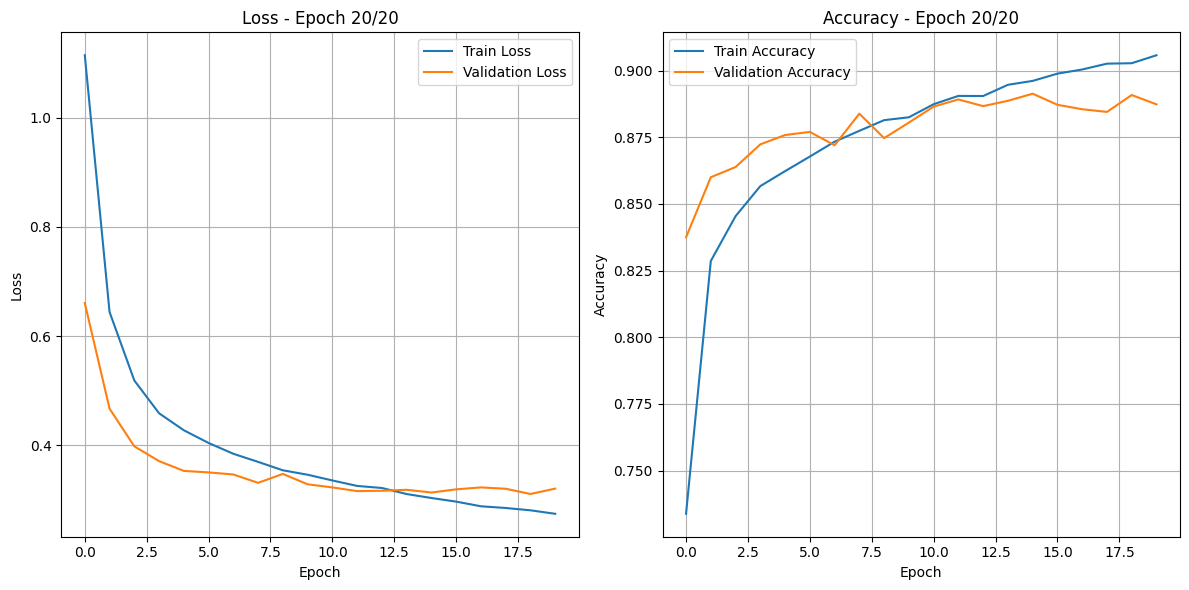

Epoch 20/20: Train Loss = 0.2746, Validation Loss = 0.3207, Train Accuracy = 90.57%, Validation Accuracy = 88.73%


In [ ]:
train(
    model,
    opt,
    loss_func,
    training_params,
    loss_history,
    accuracy_history,
    train_loader,
    validation_loader,
)

In [62]:
def test(model, test_loader):
    test_progress_bar = tqdm(test_loader, desc="Testing", leave=False)

    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for features, labels in test_progress_bar:
            features = features.to(device)
            labels = labels.to(device)

            logits = model(features)

            _, predicted_labels = torch.max(logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
test(model, test_loader)

Test Accuracy: 88.56%


#### CNN

In [49]:
class TinyCNN(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # global average pooling
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, input_data):
        output_data = self.model(input_data)
        return output_data

In [50]:
summary(TinyCNN(), (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         Dropout2d-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
              ReLU-5           [-1, 16, 28, 28]               0
         MaxPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           4,640
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
          Dropout-10           [-1, 32, 14, 14]               0
        MaxPool2d-11             [-1, 32, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          18,496
             ReLU-13             [-1, 64, 7, 7]               0
AdaptiveAvgPool2d-14             [-1, 6

In [56]:
model = TinyCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [57]:
training_params = {"n_epochs": 10}
loss_history = {"train": [], "validation": []}
accuracy_history = {"train": [], "validation": []}

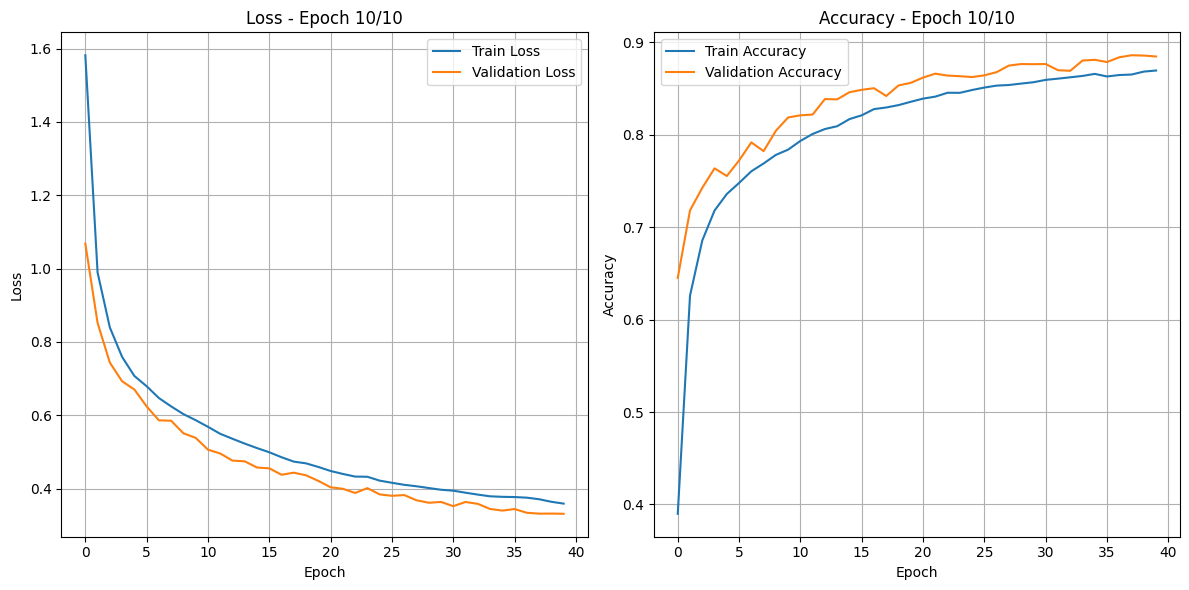

Epoch 10/10: Train Loss = 0.3593, Validation Loss = 0.3315, Train Accuracy = 86.96%, Validation Accuracy = 88.48%


In [61]:
train(
    model,
    opt,
    loss_func,
    training_params,
    loss_history,
    accuracy_history,
    train_loader,
    validation_loader,
)

In [63]:
test(model, test_loader)

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 88.40%


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# reduce size of train and validation datasets
reduce_factor = 0.01
reduced_train_len = round(len(fmnist_dataset_train) * reduce_factor)
reduced_validation_len = round(len(fmnist_dataset_validation) * reduce_factor)

reduced_train_idxs = np.random.choice(
    len(fmnist_dataset_train), reduced_train_len, replace=False
)
reduced_validation_idxs = np.random.choice(
    len(fmnist_dataset_validation), reduced_validation_len, replace=False
)

fminst_dataset_train_reduced = torch.utils.data.Subset(
    fmnist_dataset_train, reduced_train_idxs
)
fminst_dataset_validation_reduced = torch.utils.data.Subset(
    fmnist_dataset_validation, reduced_validation_idxs
)

train_loader_reduced = torch.utils.data.DataLoader(
    fminst_dataset_train_reduced, batch_size=64, shuffle=True, num_workers=2
)
validation_loader_reduced = torch.utils.data.DataLoader(
    fminst_dataset_validation_reduced, batch_size=64, shuffle=False, num_workers=2
)

In [ ]:
len(fminst_dataset_train_reduced), len(fminst_dataset_validation_reduced)

(540, 60)

In [ ]:
training_params = {"n_epochs": 50}
loss_history = {"train": [], "validation": []}
accuracy_history = {"train": [], "validation": []}

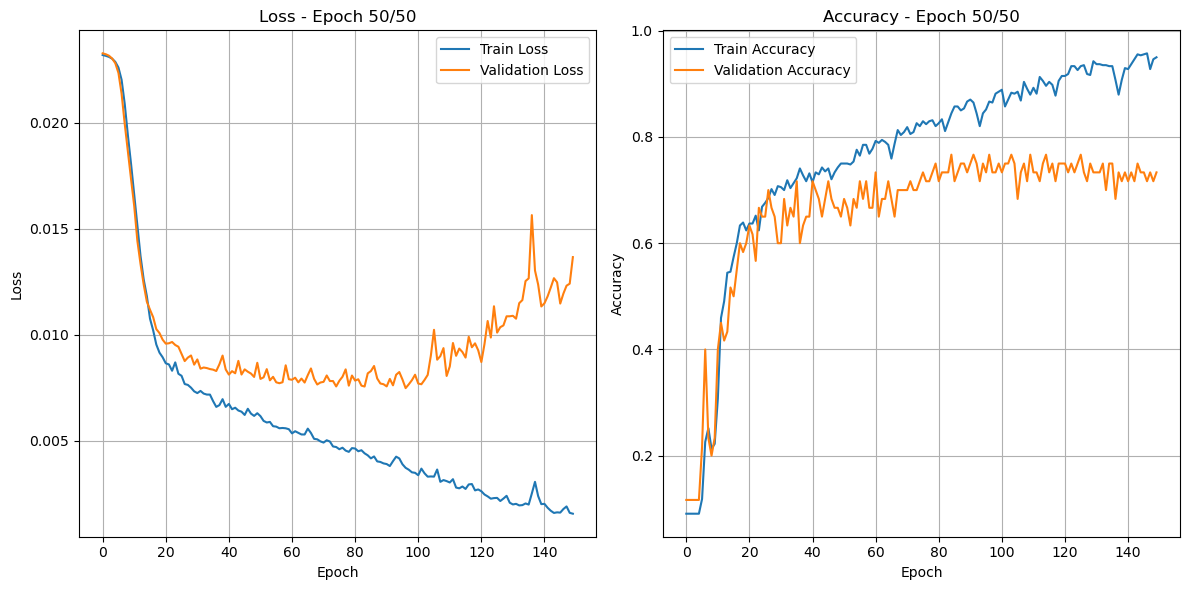

Epoch 50/50: Train Loss = 0.0016, Validation Loss = 0.0137, Train Accuracy = 95.00%, Validation Accuracy = 73.33%


In [ ]:
train(
    model,
    opt,
    loss_func,
    training_params,
    loss_history,
    accuracy_history,
    train_loader_reduced,
    validation_loader_reduced,
)

In [ ]:
test(model, test_loader)

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 68.38%


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [ ]:
training_params = {"n_epochs": 10}

In [ ]:
loss_history = {"train": [], "validation": []}
accuracy_history = {"train": [], "validation": []}

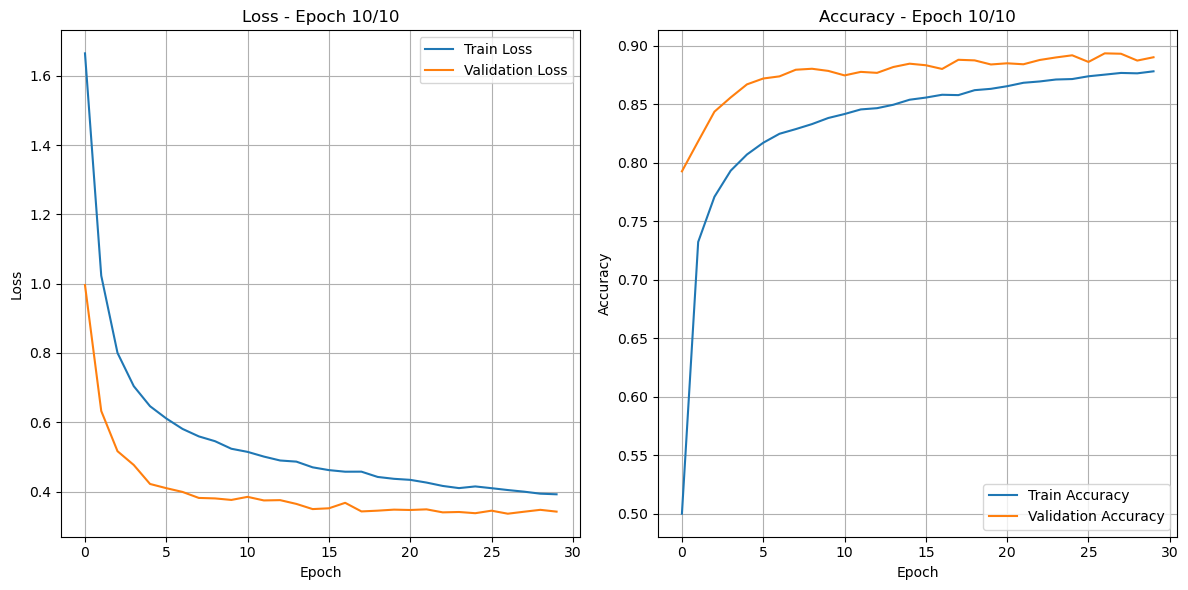

Epoch 10/10: Train Loss = 0.3921, Validation Loss = 0.3421, Train Accuracy = 87.80%, Validation Accuracy = 89.00%


In [ ]:
train(
    model,
    opt,
    loss_func,
    training_params,
    loss_history,
    accuracy_history,
    train_loader,
    validation_loader,
)

In [ ]:
test(model, test_loader)

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 88.21%


### Conclusions:

Neural networks are prone to overfitting, especially when they have a large number of parameters relative to the amount of training data. Overfitting occurs when the model learns to perform very well on the training data but fails to generalize to unseen data. It is crucial to monitor the model's performance not only on the training data but also on a separate validation set during training to detect and prevent overfitting.

To mitigate overfitting, several regularization techniques can be employed, including:

* **Dropout:** Randomly drops units (along with their connections) during training to prevent co-adaptation of hidden units, effectively reducing the model's capacity and improving generalization.

* **Batch Normalization:** While primarily used to stabilize and accelerate training by normalizing the inputs to each layer, Batch Normalization can have a mild regularization effect by adding noise to the learning process. However, it is not primarily a regularization technique.

* **Network Architecture Modification:** Reducing the model's capacity by decreasing the number of layers or units (e.g., reducing the number of neurons or layers) or using techniques like weight pruning. A smaller model is less likely to overfit, especially when the training data is limited.

It's also important to note other regularization techniques like **L1/L2 regularization (weight decay)** and **data augmentation** that can also play a significant role in preventing overfitting.